(своя тема)
Это анализатор для трех сообществ вконтакте (лингвистическое, футбольное и новостное). 
Для каждого сообщества программа находит самое популярное ПРИЛАГАТЕЛЬНОЕ за последние 100 постов (без учета стоп-слов) и, используя его 
как начальный узел для семантического поля (в которое уже входят слова разных частей речи), строит граф. 

In [1]:
import urllib.request
import json
import re
import os
from pymystem3 import Mystem
import gensim
from gensim.models import word2vec
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import style
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [2]:
def words():
    vk_ids = ['-46299096', '-217557', '-76982440']
    tops = ''

    for i in vk_ids:
        vk_id = i
        token = 'ce9bbc81ce9bbc81ce9bbc81f7cef1aec5cce9bce9bbc8192236d' \
                '27163fe4bf62eb1946'
        req = urllib.request.Request('https://api.vk.com/method/wall.get'
                                     '?owner_id=%s&count=100&access_token='
                                     '%s&v=5.95' % (vk_id, token))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
        posts = data['response']['items']
        all_text = ''

        for post in posts:
            text = post['text']
            plain = re.sub('[^а-яА-Я\s]', '', text)
            all_text += plain

        m = Mystem()
        everything = m.lemmatize(str(all_text))
        adj = []
        for thing in everything:
            if str(thing).endswith('ый'):
                adj.append(thing)
        lemmas = []
        sw = stopwords.words('russian')
        for a in adj:
            if a not in sw and str(a) != 'который' and str(a) != 'самый':
                lemmas.append(a)
        top_lem = Counter(lemmas)
        top_lem = dict(top_lem)
        top_lem = {c: top_lem[c] for c in top_lem
                   if top_lem[c] > 1 and len(c) > 1}
        top_lem = (sorted(top_lem.items(), key=lambda x:
                          x[1], reverse=True))[:1]
        print(top_lem)
        for i in dict(top_lem).keys():
            tops += i + ' '
    with open('tops.txt', 'w+', encoding='utf-8') as f:
        f.write(tops)

In [3]:
if __name__ == '__main__':
    words()

[('разный', 16)]
[('финальный', 27)]
[('уголовный', 4)]


In [2]:
urllib.request.urlretrieve(
    'http://rusvectores.org/static/models/rusvectores2/'
    'ruscorpora_mystem_cbow_300_2_2015.bin.gz',
    'ruscorpora_mystem_cbow_300_2_2015.bin.gz')

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0xf5bd6f0>)

In [3]:
m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)

c:\users\vital\appdata\local\programs\python\python37-32\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
with open('tops.txt', 'r', encoding='utf-8') as f:
    words = f.read()
    words = words.split()

print(words)

['разный', 'финальный', 'уголовный']


разный_A


c:\users\vital\appdata\local\programs\python\python37-32\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


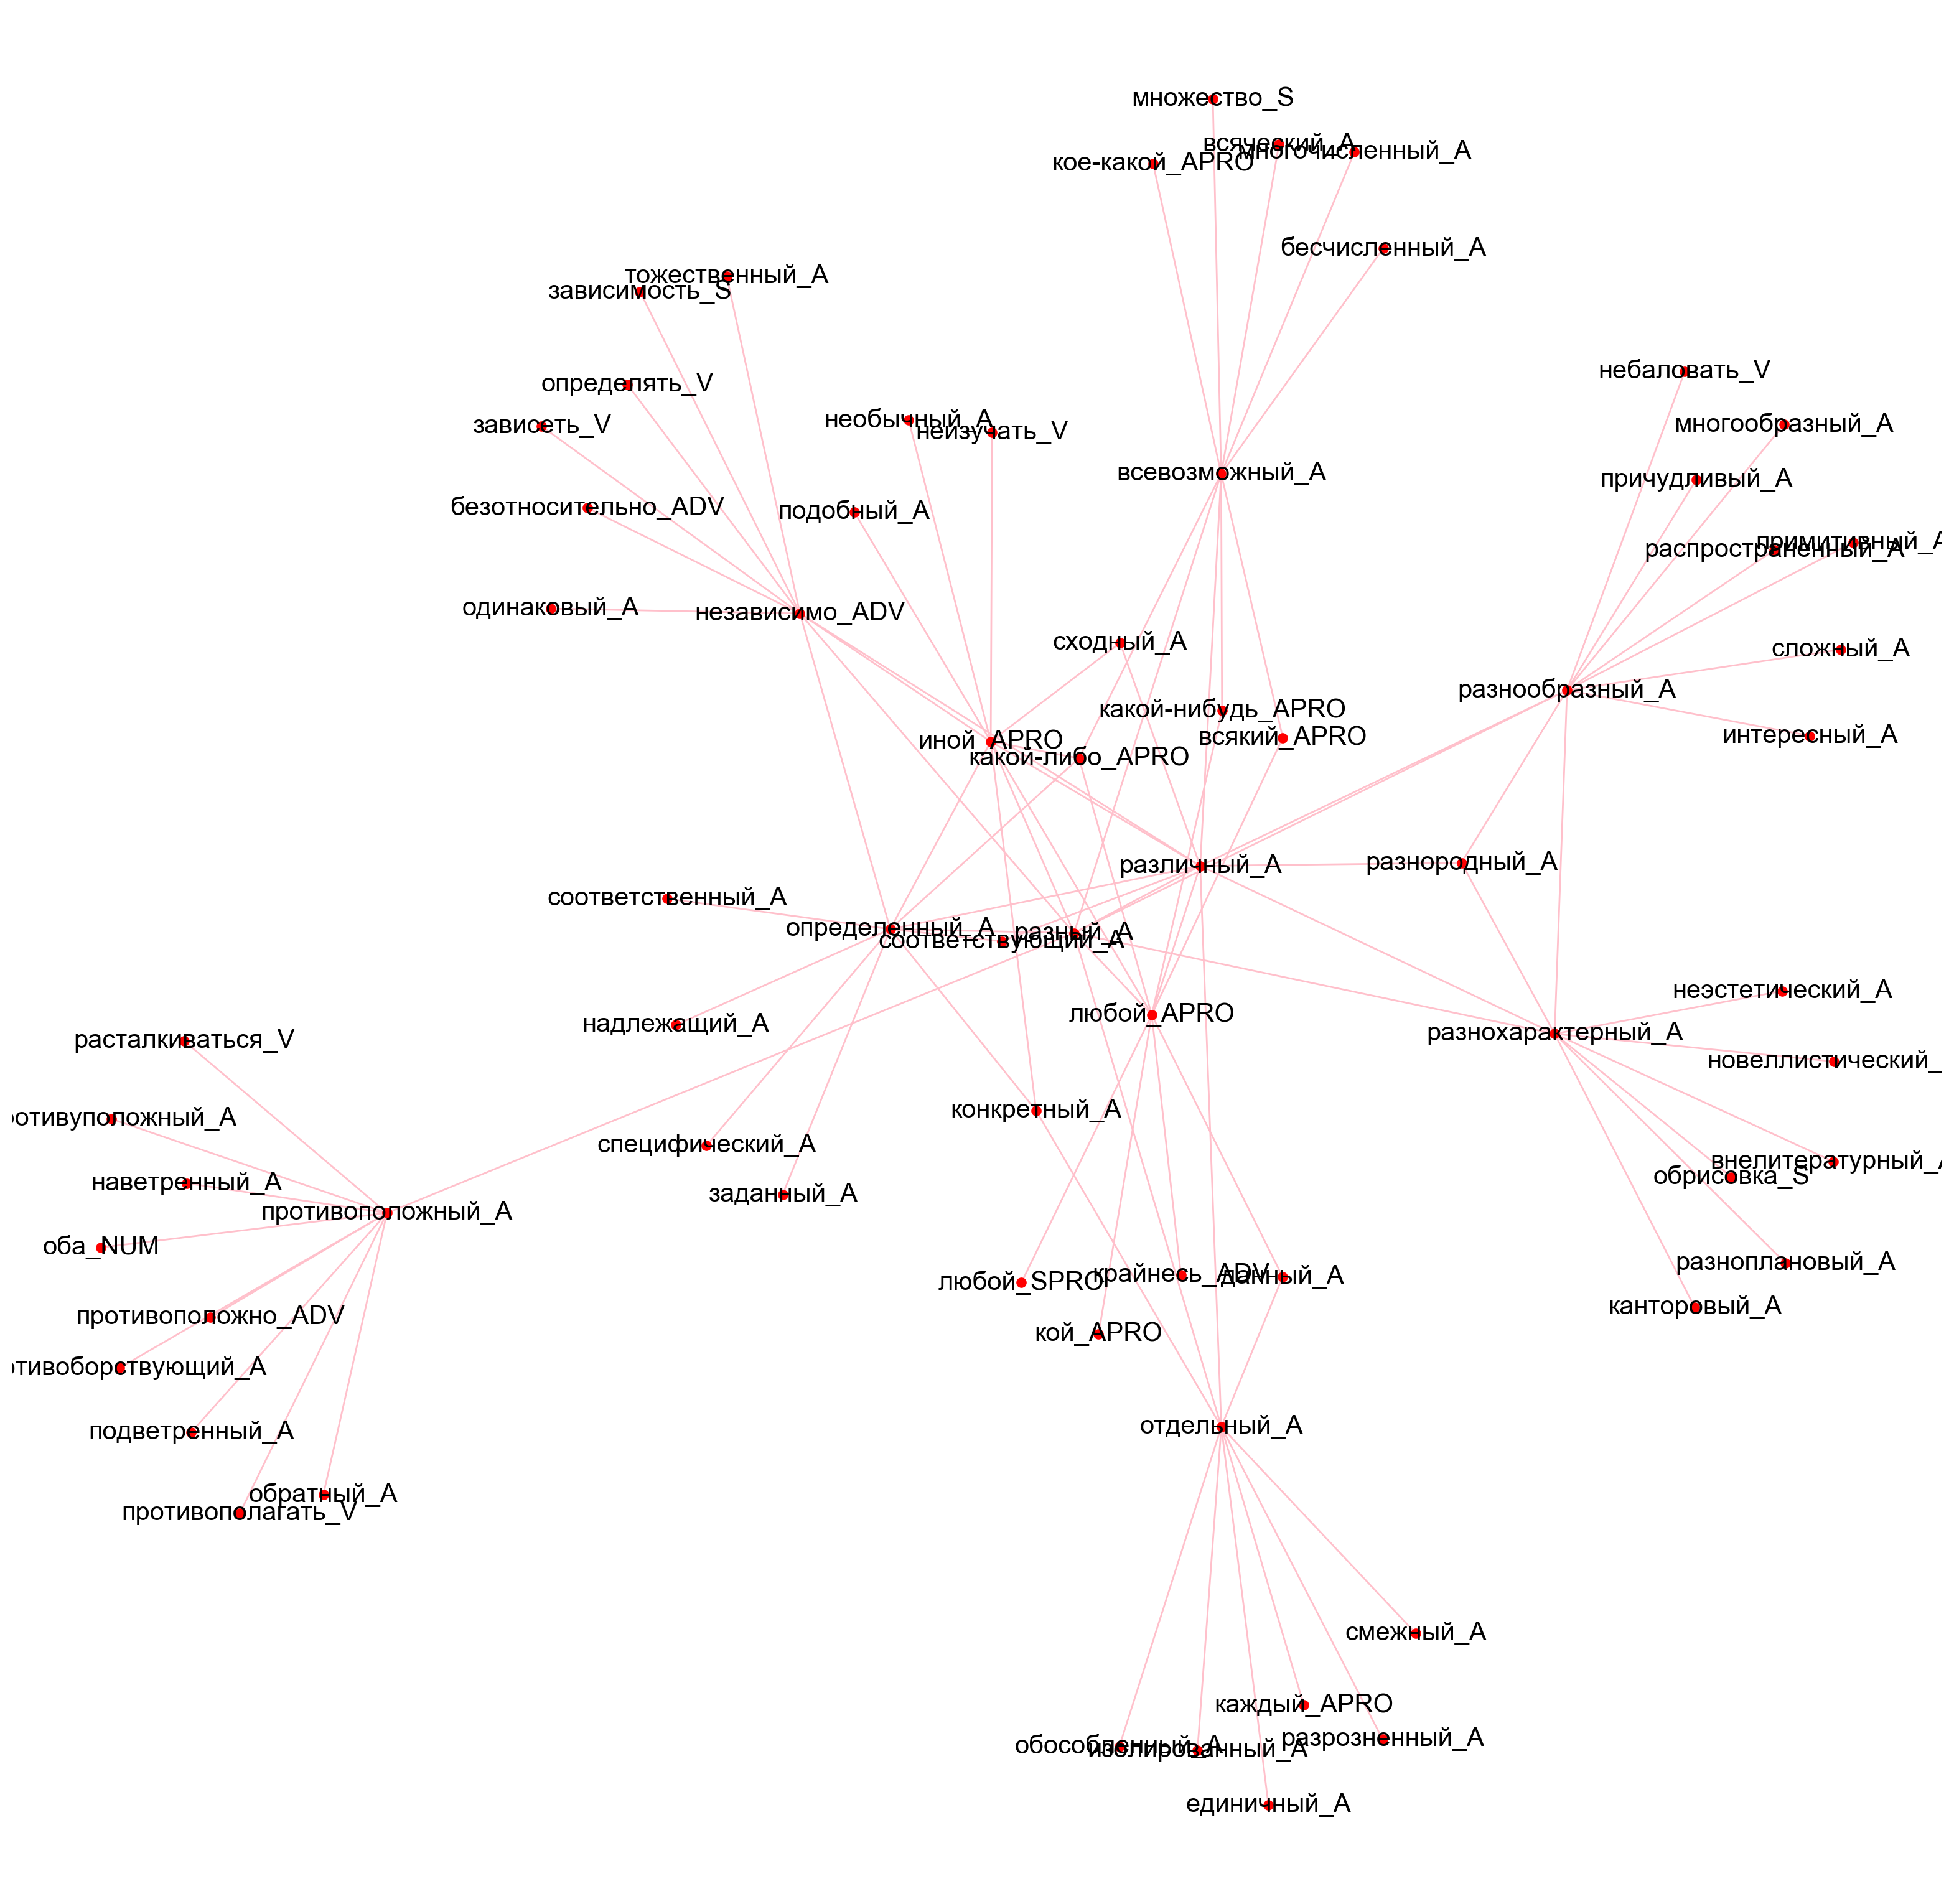

финальный_A


c:\users\vital\appdata\local\programs\python\python37-32\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


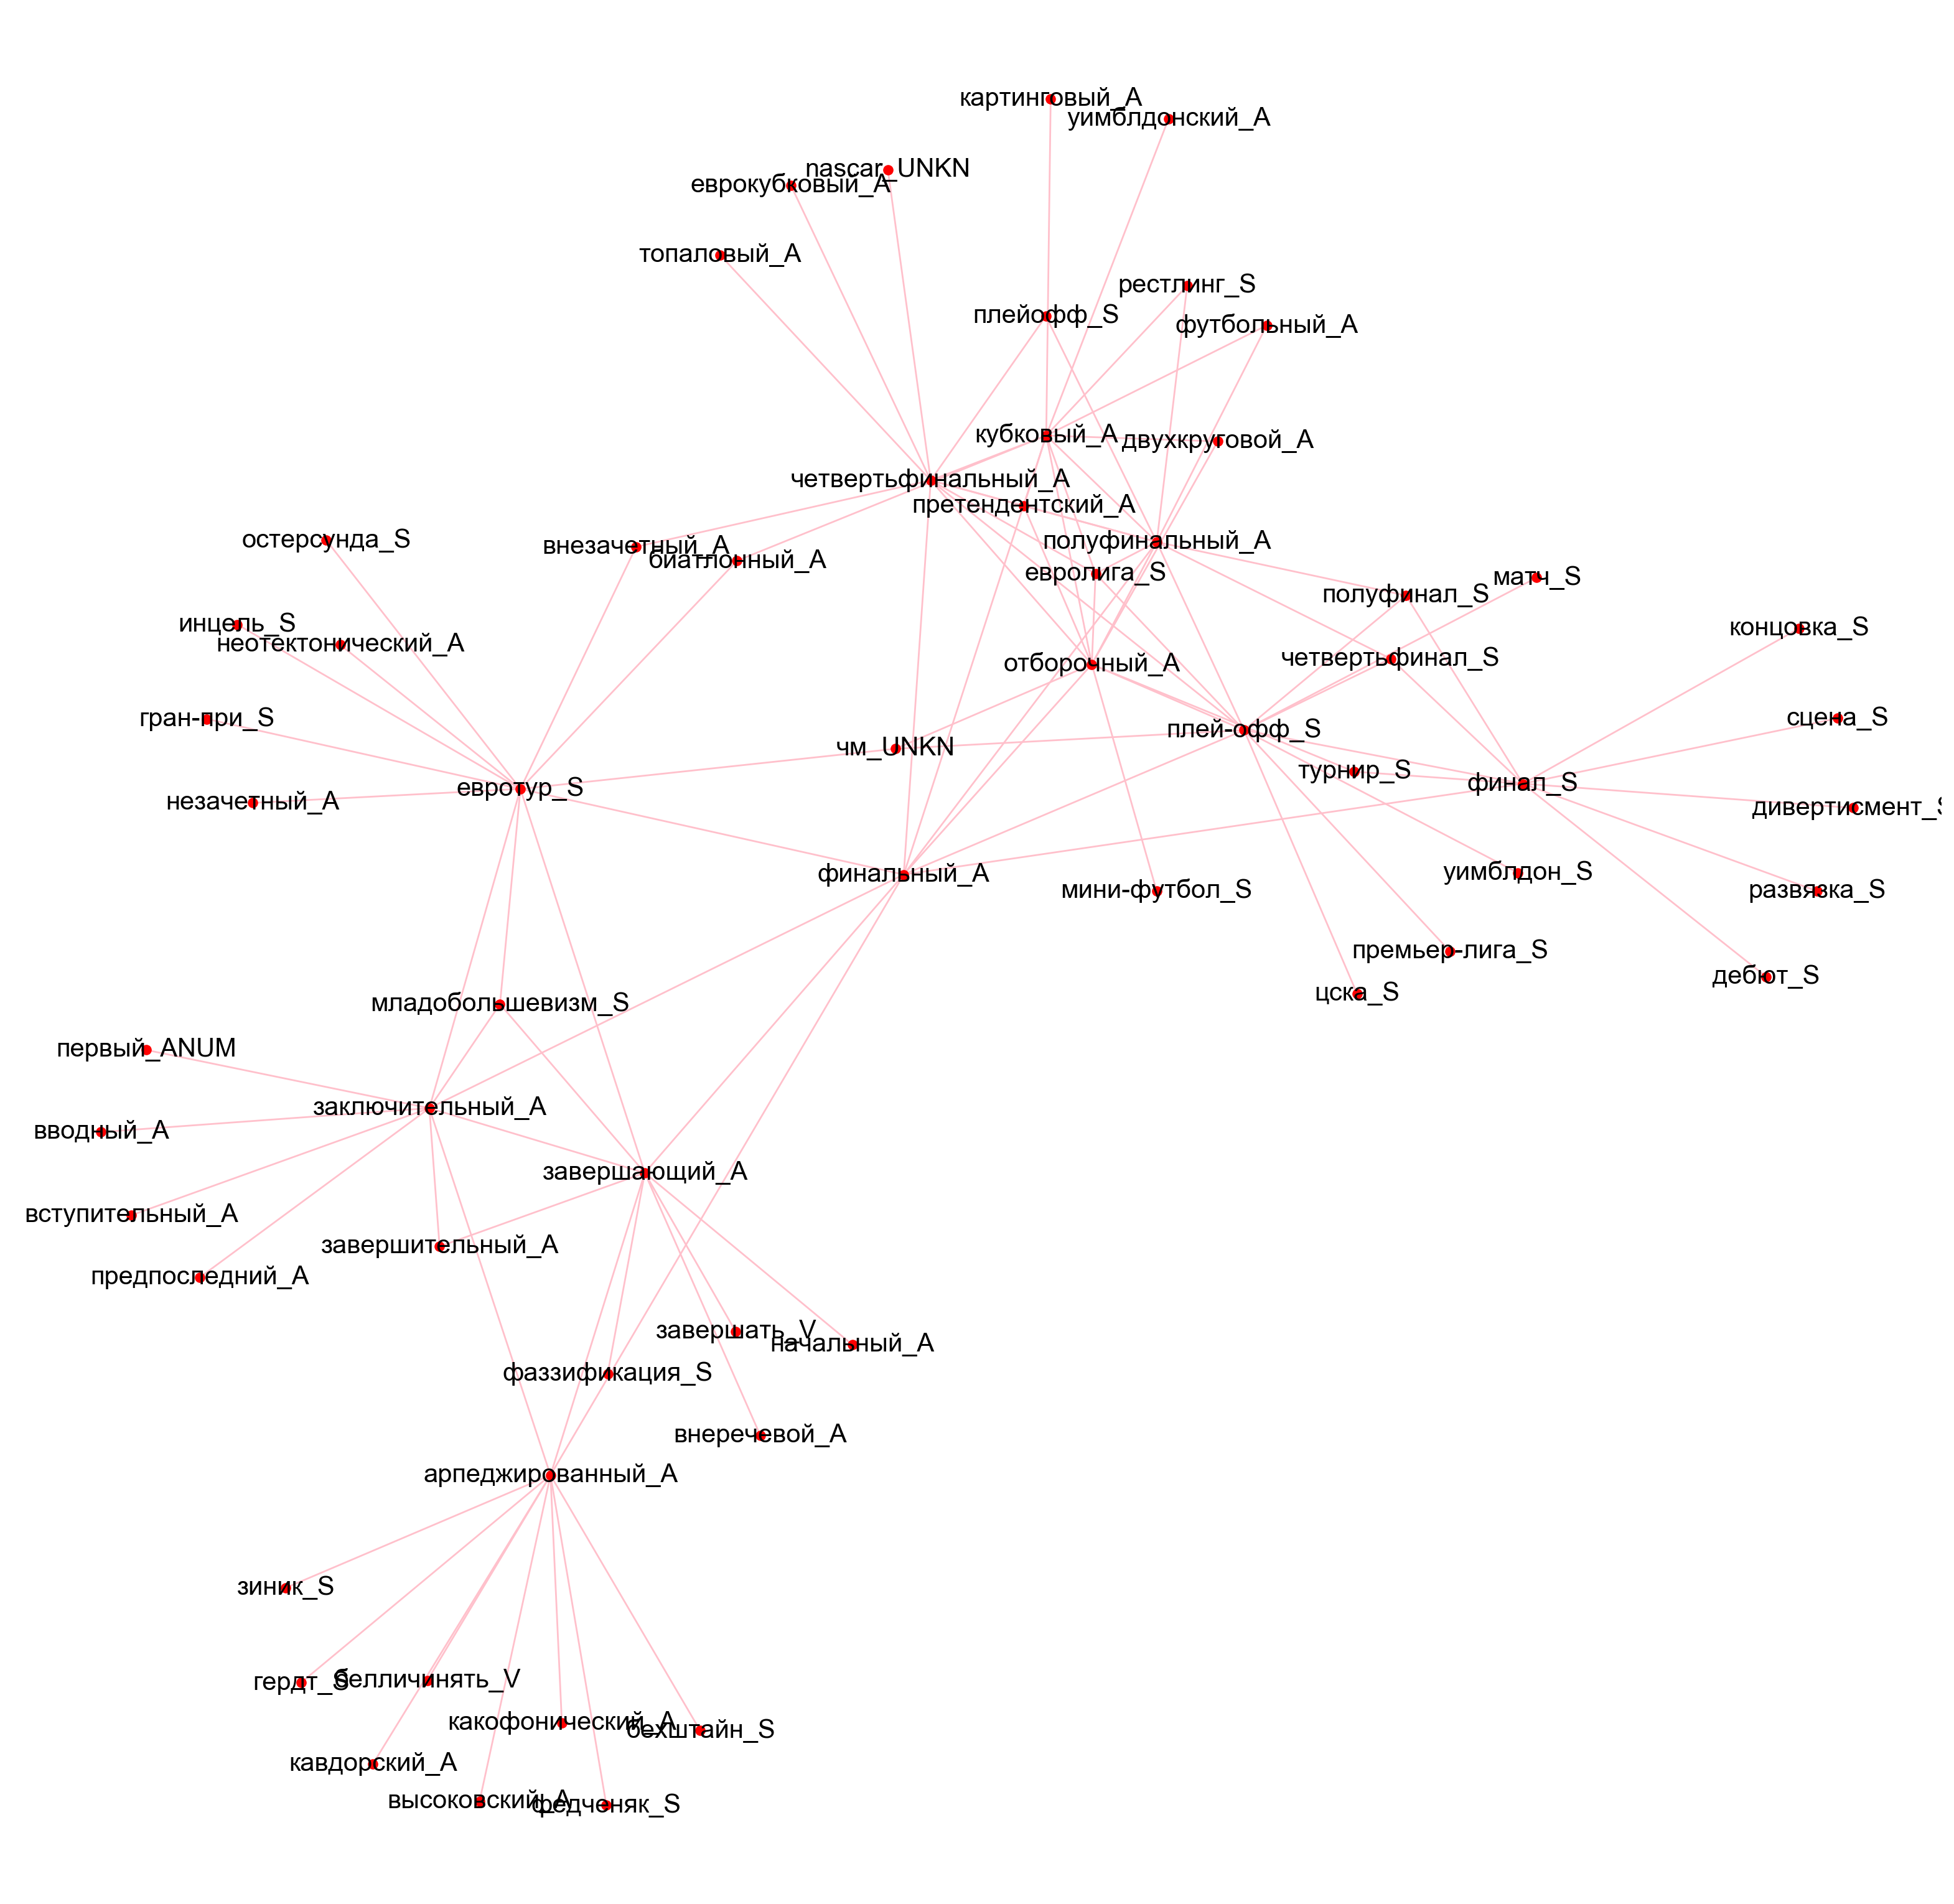

уголовный_A


c:\users\vital\appdata\local\programs\python\python37-32\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


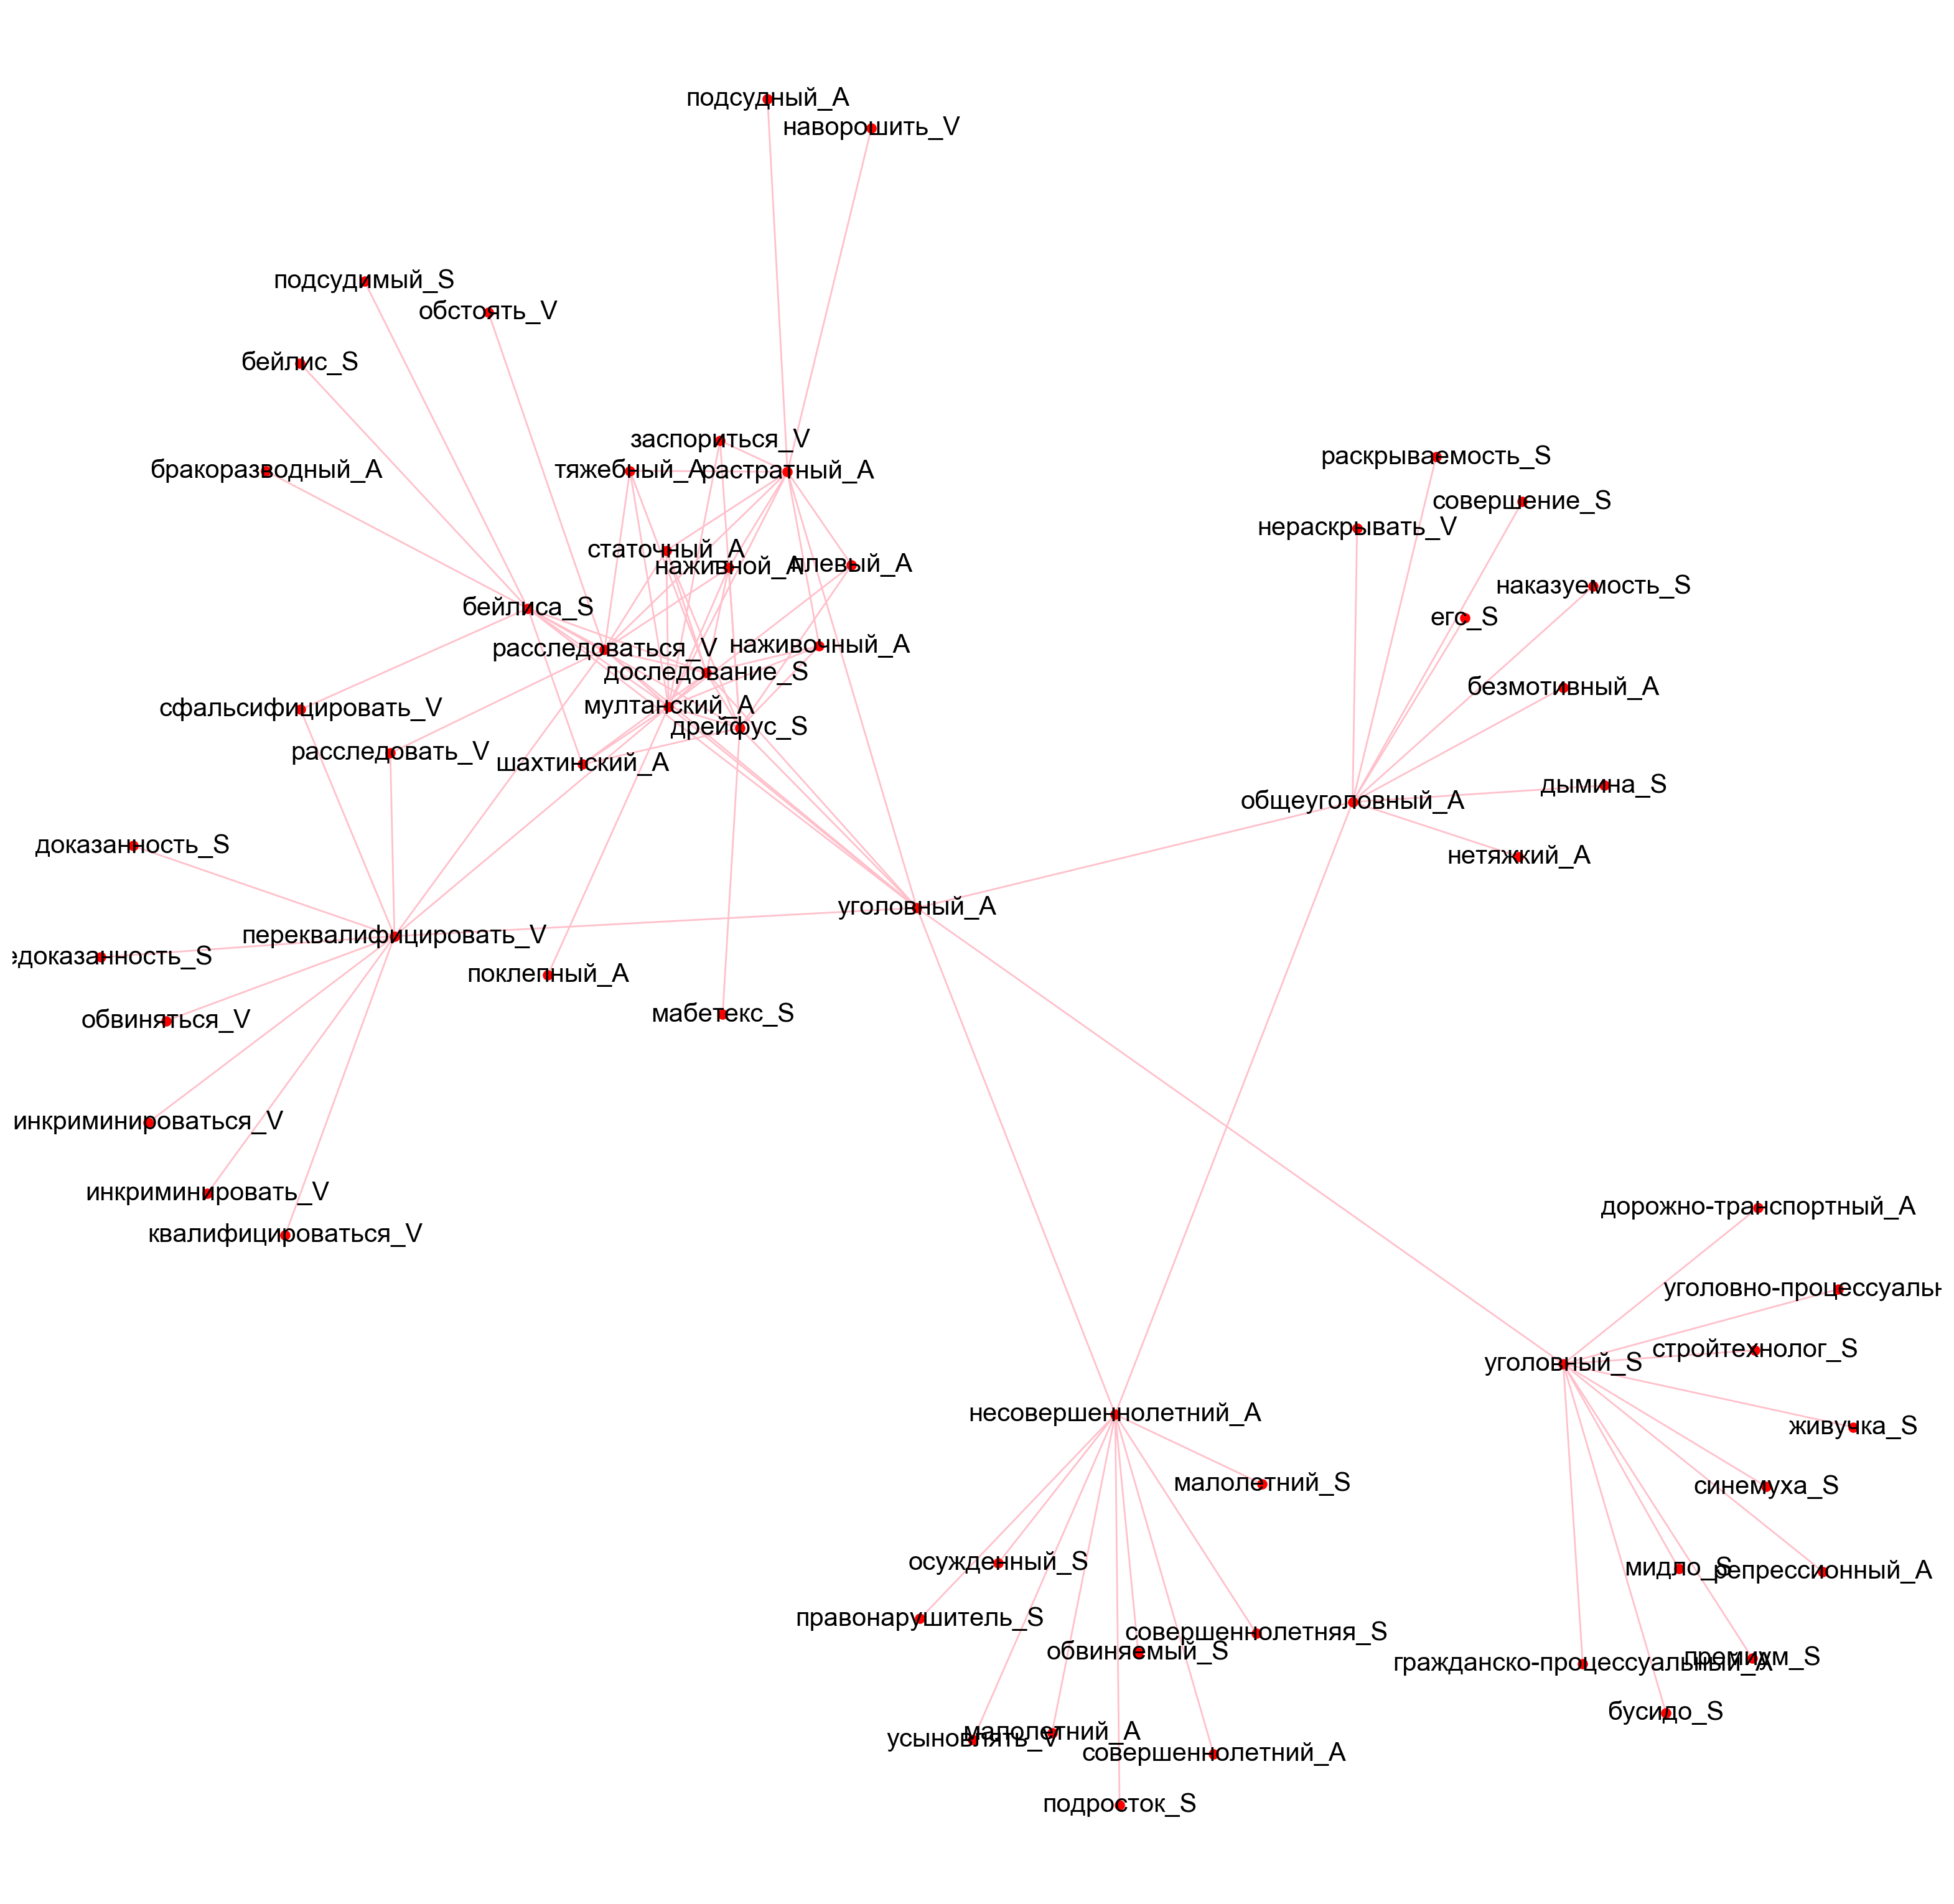

In [13]:
for word in words:
    filename = '%s.png' % word
    G = nx.Graph()

    level_one = []
    word = str(word) + '_A'
    if word in model:
        print(word)
        syn_words = len(model[word])
        for i in model.most_similar(positive=[word], topn=10):
            level_one.append(i[0])
            G.add_node(i[0], label=str(i[0]))
            G.add_edge(str(word), str(i[0]))
    else:
        print('Увы, слова "%s" нет в модели!' % word)

    level_two = []
    for word in level_one:
        if word in model:
            for i in model.most_similar(positive=[word], topn=10):
                level_two.append(i[0])
                G.add_node(i[0], label=str(i[0]))
                G.add_edge(str(word), str(i[0]))
        else:
            print('Увы, слова "%s" нет в модели!' % word)

    style.use('ggplot')

    pos = nx.spring_layout(G)
    plt.figure(figsize=(20, 20), dpi=200)
    nx.draw_networkx_nodes(G, pos, node_color='red', node_size=30)
    nx.draw_networkx_edges(G, pos, edge_color='pink')
    nx.draw_networkx_labels(
                G, pos, font_size=15, font_family='Arial')
    plt.axis('off')
    plt.savefig(filename, format='png')
    plt.show()